In [1]:
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/cweniger/swyft.git

In [2]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [3]:
DEVICE = swyft.set_device(gpu=True)
MAX_EPOCHS = 100
EXPECTED_N = 20000

In [4]:
def simulator(z):
    return np.array([z[0],2*(z[1]-z[0])])

def noise(x, z = None, noise=0.01):
    n = np.random.randn(*x.shape)*noise
    return x + n

z0 = np.array([0.55,0.45])
zdim = len(z0)
x0 = simulator(z0)  # Using Asimov data

In [5]:
cache = swyft.MemoryCache(zdim = zdim, xshape = x0.shape)

Creating new cache.


In [6]:
intensity = None

for _ in range(2):
    if intensity is None:
        intensity = swyft.get_unit_intensity(expected_n=EXPECTED_N, dim=zdim)
    else:
        intensity = swyft.get_constrained_intensity(
            expected_n=EXPECTED_N,
            ratio_estimator=re,
            x0=x0,
            threshold=1e-4,
            #factor_mask=intensity.factor_mask,
        )
    cache.grow(intensity)
    cache.simulate(simulator)
    points = swyft.Points(cache, intensity, noise)
    re = swyft.RatioEstimator(points, device=DEVICE)
    re.train(max_epochs=MAX_EPOCHS, batch_size=32, lr_schedule=[1e-3, 3e-4, 1e-4])

Simulate:   1%|          | 182/20183 [00:00<00:11, 1816.88it/s]

Adding 20183 new samples. Run simulator!


Simulate: 100%|██████████| 20183/20183 [00:11<00:00, 1833.16it/s]


yshape (shape of features between head and legs): 2
Start training
No new simulator runs required.
LR iteration 0
Validation loss: 92.29643338918686
Validation loss: 83.36673060059547
Validation loss: 84.38964462280273
Total epochs: 3
LR iteration 1
Validation loss: 67.95769682526588
Validation loss: 62.36377640068531
Validation loss: 65.75764295458794
Total epochs: 3
LR iteration 2
Validation loss: 59.76362067461014
Validation loss: 60.51450261473656
Total epochs: 2


Simulate:   0%|          | 0/19915 [00:00<?, ?it/s]

Constrained posterior area: 0.011456301856369065
Adding 19915 new samples. Run simulator!


Simulate: 100%|██████████| 19915/19915 [00:10<00:00, 1852.05it/s]


yshape (shape of features between head and legs): 2
Start training
No new simulator runs required.
LR iteration 0
Validation loss: 244.40118217468262


KeyboardInterrupt: 

In [ ]:
swyft.plot1d(re, x0 = x0, z0 = z0, cmap = 'Greys')

In [30]:
re2 = swyft.RatioEstimator(points, combinations = [[0, 1]], device=DEVICE)
re2.train(max_epochs=MAX_EPOCHS, batch_size=32, lr_schedule=[1e-3, 3e-4, 1e-4])

yshape (shape of features between head and legs): 2
Start training
LR iteration 0
Validation loss: 52.19612981379032
Validation loss: 55.09544947743416
Total epochs: 2
LR iteration 1
Validation loss: 40.12826035916805
Validation loss: 42.59993401169777
Total epochs: 2
LR iteration 2
Validation loss: 40.12063875794411
Validation loss: 42.59800988435745
Total epochs: 2


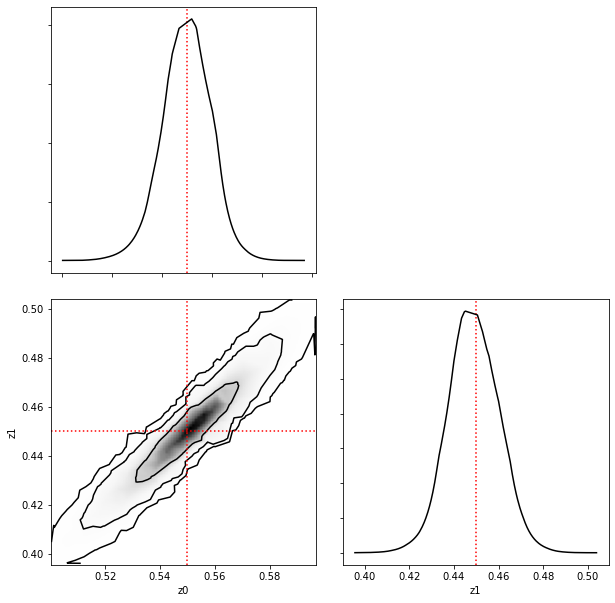

In [31]:
swyft.corner(re, re2, x0 = x0, z0 = z0, cmap = 'Greys', dim = 10, max_n_points = 10000)